In [ ]:
#pip install numpy==1.21
#pip install opendatasets
#pip install pycaret==2.3.5
#pip install scipy==1.4.1
#pip install numba==0.53

In [1]:
import pandas as pd
import opendatasets as od
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from pycaret.anomaly import *

In [2]:
od.download("https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset")
# username: mfarhat
# key: 9f0ed7eeb00847f27bb17502350767a1

Skipping, found downloaded files in "./online-payments-fraud-detection-dataset" (use force=True to force download)


In [3]:
df = pd.read_csv('online-payments-fraud-detection-dataset/PS_20174392719_1491204439457_log.csv')
#df.head

In [9]:
# caracteristicas da base
df.shape

(6362620, 11)

In [11]:
# volumetria da fraude
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [ ]:
df[df['isFlaggedFraud'] == 1][df['isFraud'] == 1]

In [14]:
# verificando se tem algum caso em que nameOrig == nameDest
df['nova_var'] = df['nameOrig'] == df['nameDest']
df[df['nova_var'] == 'True']

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,nova_var


In [ ]:
# vendo alguns casos com nameOrig que aparece + de 1 vez
base_fraudulenta = df[df['isFraud']==1]
verificacao = [base_fraudulenta['nameDest'].value_counts(ascending=False) > 1]
verificacao

MODIFICANDO PARA DF FINAL

In [23]:
df_final = df[['type','amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']].copy(deep=True)

In [24]:
df_final.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03
std,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


In [17]:
count_nan = df_final.isna().sum().sum()
print ('contagem obs nulas: ' + str(count_nan))

contagem obs nulas: 0


In [5]:
df_final = pd.get_dummies(df_final, columns = ['type'], prefix = ['type'])
#df_final.head()

In [6]:
# variaveis explicativas numéricas boxplot
colunas_numericas = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
#sns.boxplot(df[colunas_numericas])

Normalização das variáveis

In [7]:
# normalizando variaveis numericas
df_final[colunas_numericas] = Normalizer().fit_transform(df_final[colunas_numericas])
#df_final.head()

Boxplot

[Text(0, 0, 'amount'),
 Text(1, 0, 'oldbalanceOrg'),
 Text(2, 0, 'newbalanceOrig'),
 Text(3, 0, 'oldbalanceDest'),
 Text(4, 0, 'newbalanceDest')]

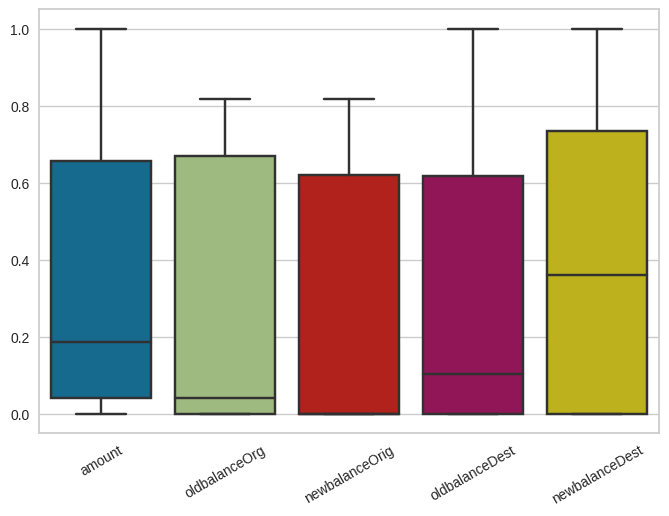

In [8]:
# boxplot das variáveis numericas normalizadas
ax = sns.boxplot(df_final[colunas_numericas])
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

Matriz de correlação

In [9]:
df_final[colunas_numericas].corr()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
amount,1.000000,-0.324564,-0.392127,-0.534250,-0.351102
oldbalanceOrg,-0.324564,1.000000,0.792347,-0.523559,-0.589659
newbalanceOrig,-0.392127,0.792347,1.000000,-0.400964,-0.595266
oldbalanceDest,-0.534250,-0.523559,-0.400964,1.000000,0.780250
newbalanceDest,-0.351102,-0.589659,-0.595266,0.780250,1.000000


### Modelagem

Base Treino e Teste (Proporção 70/30)

In [10]:
df_final_resposta = df_final.isFraud
df_final_explicativas = df_final[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']]

# 70/30% base treino e teste
base_treino, base_teste, resposta_treino, resposta_teste = train_test_split(df_final_explicativas, df_final_resposta, test_size = 0.3)

base_treino.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
4803863,0.054577,0.000000,0.000000,0.678237,0.732814,0,1,0,0,0
4150436,0.707106,0.001287,0.000000,0.000000,0.707106,0,1,0,0,0
2466429,0.005211,0.702352,0.707563,0.057454,0.052242,1,0,0,0,0
4116051,0.001574,0.251040,0.252614,0.661530,0.659955,1,0,0,0,0
2803098,0.057770,0.734220,0.676449,0.000000,0.000000,0,0,0,1,0


#### Regressão Logística

In [11]:
reg_log = LogisticRegression(max_iter=500)
reg_log.fit(base_treino, resposta_treino)

LogisticRegression(max_iter=500)

In [12]:
base_teste_predict_reg_log = reg_log.predict(base_teste)

### Árvore de Decisão

In [13]:
arv_decisao = DecisionTreeClassifier()
arv_decisao.fit(base_treino, resposta_treino)

DecisionTreeClassifier()

In [14]:
base_teste_predict_arv_decisao = arv_decisao.predict(base_teste)

### Randon Forest

In [15]:
randon_forest = RandomForestClassifier()
randon_forest.fit(base_treino, resposta_treino)

RandomForestClassifier()

In [16]:
base_teste_predict_random_forest = arv_decisao.predict(base_teste)

### Anomaly Detection

In [17]:
cat_feat =  ['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']
numeric_feat = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

In [19]:
anom = setup(data = base_treino, silent = True, categorical_features = cat_feat, numeric_features = numeric_feat)

,Description,Value
0,session_id,2383
1,Original Data,"(4453834, 10)"
2,Missing Values,False
3,Numeric Features,5
4,Categorical Features,5
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(4453834, 15)"
9,CPU Jobs,-1


In [22]:
# models()
anomaly_detec = create_model(model = 'iforest', fraction = 0.05)                                                                                                                                                                                                                                                                                                                                                                                                 

KeyboardInterrupt: 

In [ ]:
resultados = assign_model(anomaly_detec)

In [ ]:
# save_model(model = anomaly_detec, model_name = 'iforest_model')
# loaded_model = load_model('iforest_model')

## Score on unseen data
# loaded_model.predict(base_teste)

## Probability of a record being classified as 0 or 1
# loaded_model.predict_proba(base_teste)

## Anomaly score
# loaded_model.decision_function(base_teste)

anomaly detection: https://towardsdatascience.com/unsupervised-anomaly-detection-in-python-f2e61be17c2b